In [ ]:
!pip install pennylane

In [ ]:
import pennylane as qml

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import time

from sklearn.datasets import make_blobs

#Preparing the DATA

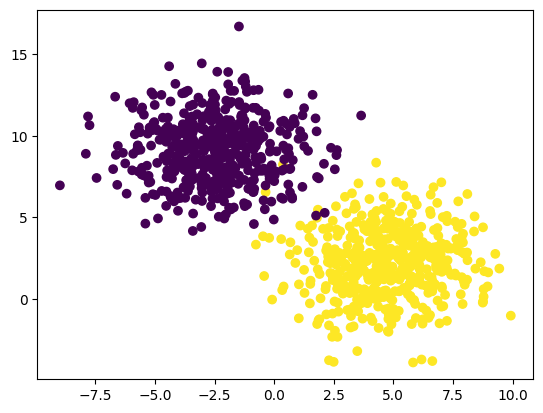

In [ ]:
n_samples = 1000

X, Y = make_blobs(n_samples, centers=2, cluster_std=[2, 2], random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis')
plt.show()

In [ ]:
x = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(Y.astype(np.float32)).view(-1,1)

#Classical model

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, 8)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(8, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.relu2(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y

net = Net()

#Quantum model

In [ ]:
n_qubits = 4
dev = qml.device("lightning.qubit", wires= n_qubits)
q_depth = 2

    #ANGLE EMBEDDING:
def angle_embedding(inputs):
    for a in range(n_qubits):
        qml.Hadamard(wires=a)

    for b in range(n_qubits):
        qml.RY(inputs[(2 * b) ], wires=b)
        qml.RZ(inputs[(2 * b) + 1], wires=b)

    #AMPLITUDE EMBEDDING:
def amplitude_embedding(inputs):
    qml.templates.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True, pad_with=0)

embedding = amplitude_embedding

@qml.qnode(dev, interface='torch')
def qnode(inputs, weights):

    embedding(inputs)

    # Variational circuit
    for i in range(q_depth):
        for j in range(n_qubits):
            qml.RY(weights[2*(i*n_qubits + j) ], wires=j)
            qml.RZ(weights[2*(i*n_qubits + j) + 1], wires=j)
        for l in range(n_qubits):
            if (l == (n_qubits - 1)):
                qml.CNOT(wires=[l,0])
            else:
                qml.CNOT(wires=[l,l+1])

    for k in range(n_qubits):
        qml.RY(weights[(2*q_depth * n_qubits) + k ], wires=k)
        qml.RZ(weights[(2*q_depth * n_qubits) + k + 1], wires=k)

    # Measurement
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [ ]:
n_args = 2*(q_depth +1) * n_qubits
weight_shapes = {"weights": n_args}

print(qml.draw(qnode)(inputs = np.random.rand(n_qubits * 2), weights = np.random.rand(n_args)))

0: ─╭|Ψ⟩──RY(0.52)──RZ(0.56)─╭●───────╭X──RY(0.87)──RZ(0.91)─╭●───────╭X──RY(0.05)──RZ(0.89)─┤  <Z>
1: ─├|Ψ⟩──RY(0.48)──RZ(0.33)─╰X─╭●────│───RY(0.13)──RZ(0.55)─╰X─╭●────│───RY(0.89)──RZ(0.67)─┤  <Z>
2: ─├|Ψ⟩──RY(0.84)──RZ(0.85)────╰X─╭●─│───RY(0.78)──RZ(0.73)────╰X─╭●─│───RY(0.67)──RZ(0.75)─┤  <Z>
3: ─╰|Ψ⟩──RY(0.72)──RZ(0.16)───────╰X─╰●──RY(0.50)──RZ(0.83)───────╰X─╰●──RY(0.75)──RZ(0.23)─┤  <Z>


In [ ]:
class QNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 8)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(4, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.qlayer_1(dout[0])
        h2 = self.relu2(a2.unsqueeze(0))
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y

qnet = QNet()

#Training functions

In [ ]:
def train_epoch(model, opt, criterion, X, Y):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0)):
        x_batch = X[beg_i:beg_i + 1, :]
        y_batch = Y[beg_i:beg_i + 1, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = model(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()
        losses.append(loss.data.numpy())
    return losses

#Trainig the classical model

In [ ]:
# Define Optimizer and loss function
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

Execution time: 12.990710020065308


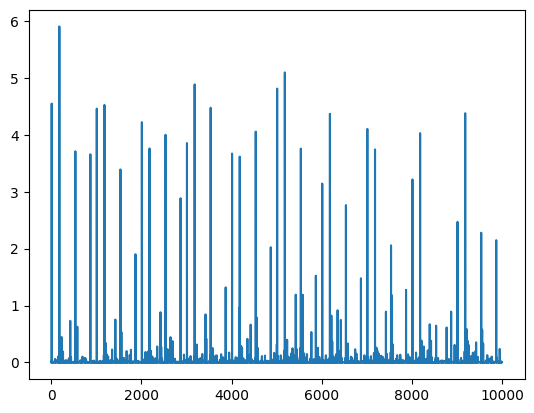

In [ ]:
start = time.time()
e_losses = []
num_epochs = 10
for e in range(num_epochs):
    e_losses += train_epoch(net, opt, criterion, x, y)
plt.plot(e_losses)
end = time.time()
print("Execution time:", end - start)

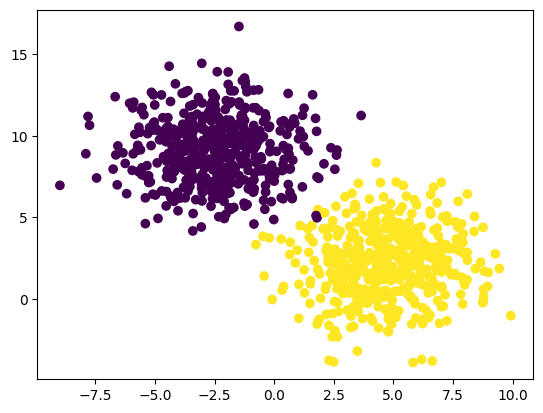

In [ ]:
test_pred = torch.round(net(x))
plt.scatter(X[:, 0], X[:, 1], c=test_pred[:, 0].detach().numpy() ,cmap='viridis')

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

print("accuracy: ", accuracy_fn(y, test_pred))

accuracy:  99.6


#Trainig the quantum model

In [ ]:
# Define Optimizer and loss function
q_opt = optim.Adam(qnet.parameters(), lr=0.02, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [ ]:
start = time.time()
e_losses_q = []
num_epochs = 10
for e in range(num_epochs):
    e_losses_q += train_epoch(qnet, q_opt, criterion, x, y)
    if (e % 10 == 0):
        print(e)
plt.plot(e_losses_q)
end = time.time()
print("Execution time", end - start)

accuracy:  93.4


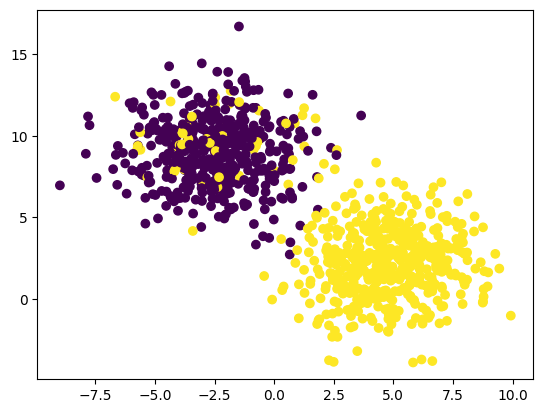

In [ ]:
test_pred_q = torch.empty((1000,1))
for i in range(0, x.size(0)):
    x_temp = x[i:i + 1, :]
    test_pred_q[i] = torch.round(qnet(x_temp))

plt.scatter(X[:, 0], X[:, 1], c=test_pred_q[:, 0].detach().numpy() ,cmap='viridis')

print("accuracy: ", accuracy_fn(y, test_pred_q))

| embedding | accuracy classical | accuracy quantum
|---|---|---|
| angle | 99.1% | 93.4% |
|  amplitude | 99.5% | ERROR |
| base | -| - |